# CI width by changing sample size for QMC and IID Beta for the Hedged (Betting) CI Method

[This JRSSB article by Ian Waudby-Smith and Aaditya Ramdas](https://academic.oup.com/jrsssb/article/86/1/1/7043257) takes $X_1, X_2, \ldots \stackrel{\text{IID}}{\sim} F$ and computes a sequential confidence interval for $\mu = \mathbb{E}(X)$.

For Quasi-Monte Carlo (QMC), also know as low discrepancy sequences, we are going to take 

$$
X_i = \frac{1}{n} \sum_{j=1}^n T_{ij},
$$ 

where for each $i$, $\{T_{ij}\}_{j=1}^n$ is a QMC set that mimics $F$. Therefore, $X_i$ is close to $\mu$, and the sequence $\{X_i\}_{i=1}^R$ is an IID sequence based on $N = nR$ samples.

In this notebook, $F$ is a Beta Distribution.


Similarly, for QMC, for $Y = f(X)$ where $X \sim U(0, 1)$ and $\mu = \mathbb{E}(Y) = \mathbb{E}(f(X))$, we are going to take

$$
Y_i = \frac{1}{n} \sum_{j=1}^n f(x_{ij})
$$ 

Therefore, $Y_i$ is close to $\mu$, and the sequence $\{Y_i\}_{i=1}^R$ is an IID sequence based on $N = nR$ samples. 

In this notebook, we use two integrands: 

$Y = f(X) = \frac{X e^X}{e}$

$Y =
f(X,Y) = 
\begin{cases} 
1, & \text{if } X + Y > \frac{2}{3} \\
0, & \text{otherwise}
\end{cases}$

We also use the following ridge functions:

1. $ g_{jmp}(w) = 1{\{w \geq 1\}} $
2. $ g_{knk}(w) = \frac {\min(\max(−2, w), 1) + 2} {3} $
3. $ g_{smo}(w) = \Phi (w)$
4. $ g_{fin}(w) = \min(1,\sqrt{\max(w + 2, 0)}/2) $

$w = \frac{1}{\sqrt{d}} \sum_{j=1}^{d}\Phi^{-1}(x_{j})$, $\Phi(.)$ is the CDF of standard Normal Distribution on R, denoted by $ \mathcal{N}(0,1)$, and $x \sim U(0, 1)^d$.

We have used DigitalNetB2 (Sobol) for QMC.

Importing the necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import beta
from confseq.betting import betting_ci_seq
from confseq.predmix import predmix_empbern_ci_seq
import qmcpy as qp
import math

The parameters used for our numerical experiments

In [2]:
alpha = 0.05 # Significance level, confidence level = 1 - alpha

# parameteres used for the beta distribution simulations

beta_param = np.array([10,30]) #parameters for the beta distribution

# parameters used for the integrand problem

f = lambda x: x[...,0]*np.exp(x[...,0])/np.exp(1) # the 1st integrand function
f_1 = lambda x: (x[...,0]+x[...,1])>(2/3) # the 2nd integrand function

# parameters used for the ridge functions

# The ridge functions:
gs = {
    "jmp": lambda w: w>=1, 
    "knk": lambda w: ((np.minimum(np.maximum(-2,w),1)) + 2) / 3,
    "smo": lambda w: norm.cdf(w),
    "fin": lambda w: np.minimum(1,((np.sqrt(np.maximum(w+2,0)))/2)),
}
d = np.array([1,2,4,16,64]) # The different d's to test on
ci_methods = np.array(["CLT", "EB", "Betting"]) # The different CI methods

# parameters used for the beta distribution, integrand problem, and ridge functions

# parameters used when R and n are not being varied

num_times = 100  #number of different times where CI will be computed
space_times = 1
    #space between different times where CI will be computed for the IID_QMC_Beta samples. For IID_Beta, space between different times equals n * space_times
R = num_times*space_times # The number of IID replications for low discrepancy or QMC samples
n = 2**5 # The number of low discrepancy or QMC samples generated per replication
N = R * n # The maximum sample size (N = mn)

# parameters used when R and n are being varied but their product is kept constant.

N_vary = 2**10 # The maximum sample size to be used. Recommended to keep a power of 2 since n must be a power of 2 (QMC rules).
n_vary = 2 ** np.arange(0, int(math.log2(N_vary)) + 1) # The vector of number of low discrepancy or QMC samples generated per replication
R_vary = N_vary // n_vary # The vector of number of IID replications for low discrepancy or QMC samples


The function to generate IID replications of QMC samples

In [4]:
def gen_qmc_samples_iid(distribution = qp.SciPyWrapper(sampler=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=beta_param[0], b = beta_param[1]))
                         , R = 11 ,n = 2**8, function = None, d_func = 1, ridge = False):
    spw = distribution
    spws = spw.spawn(R)
    x_rld = np.empty((R,n,d_func))
    for r in range(R):
        x_rld[r] = spws[r].gen_samples(n)
    if ridge is True:
        return x_rld
    if function is None:
        y_rld = x_rld[...,0]
    else:
        y_rld = function(x_rld)
    return y_rld.mean(1),y_rld.flatten()

# Using Ridge Functions:

## Varying the $R$ and $n$

IID Numerical Experiments:

In [5]:
iid_arr = np.empty((len(ci_methods),len(d),len(gs))) # consists of CIs (CLT, EB, Betting) for IID, the ridge functions, the different dimensions.
iid = qp.IIDStdUniform(d[-1],seed=7) # IID generator
x_iid = norm.ppf(iid.gen_samples(N_vary))
for j in range (len(d)):
    w_iid = x_iid[:, :d[j]].sum(axis = 1)/np.sqrt(d[j])
    counter = 0
    for g in gs.values():
        y = g(w_iid)
        iid_arr[0,j,counter] = 2 * (norm.ppf(1 - alpha / 2) * y.std(ddof = 1) / np.sqrt(N)) # CLT CI width
        lower_bound_iid_integrand_eb,upper_bound_iid_integrand_eb = predmix_empbern_ci_seq(y, times=np.array([N_vary]), alpha=alpha, parallel=True, truncation =1/2) 
        # Getting the sequential EB CI according to the code from the paper above
        iid_arr[1,j,counter] = upper_bound_iid_integrand_eb[0] - lower_bound_iid_integrand_eb[0] # The EB CI based on N_vary
        lower_bound_iid_integrand_bet,upper_bound_iid_integrand_bet = betting_ci_seq(y, times=np.array([N_vary]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
        # Getting the sequential Betting CI according to the code from the paper above
        iid_arr[2,j,counter] = upper_bound_iid_integrand_bet[0] - lower_bound_iid_integrand_bet[0] # The Betting CI based on N_vary
        counter = counter + 1

Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores


QMC Numerical Experiments:

In [6]:
qmc_arr = np.empty((len(ci_methods),len(d),len(gs), len(n_vary))) # consists of CIs (CLT, EB, Betting) for QMC, the ridge functions, the different dimensions, different R's and n's.
for i in range (len(n_vary)):
    x_qmc = norm.ppf(gen_qmc_samples_iid(distribution=qp.DigitalNetB2(d[-1],seed = 7), R = R_vary[i], n = n_vary[i],d_func = d[-1],ridge = True))
    for j in range (len(d)):
        w_qmc = x_qmc[:, :, :d[j]].sum(axis = 2)/np.sqrt(d[j])
        counter = 0
        for g in gs.values():
            y = g(w_qmc).mean(axis = 1)
            qmc_arr[0,j,counter,i] = 2 * (norm.ppf(1 - alpha / 2) * y.std() / np.sqrt(R_vary[i])) # CLT CI width
            lower_bound_qmc_integrand_eb,upper_bound_qmc_integrand_eb = predmix_empbern_ci_seq(y, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, truncation =1/2) 
            # Getting the sequential EB CI according to the code from the paper above
            qmc_arr[1,j,counter,i] = upper_bound_qmc_integrand_eb[0] - lower_bound_qmc_integrand_eb[0] # The EB CI based on N_vary
            lower_bound_qmc_integrand_bet,upper_bound_qmc_integrand_bet = betting_ci_seq(y, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
            # Getting the sequential Betting CI according to the code from the paper above
            qmc_arr[2,j,counter,i] = upper_bound_qmc_integrand_bet[0] - lower_bound_qmc_integrand_bet[0] # The Betting CI based on N_vary
            counter = counter + 1

Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 c

Here, we plot how the CLT, EB, and Betting CI width based on a total of N_vary changes as R and n changes for the different dimensions:

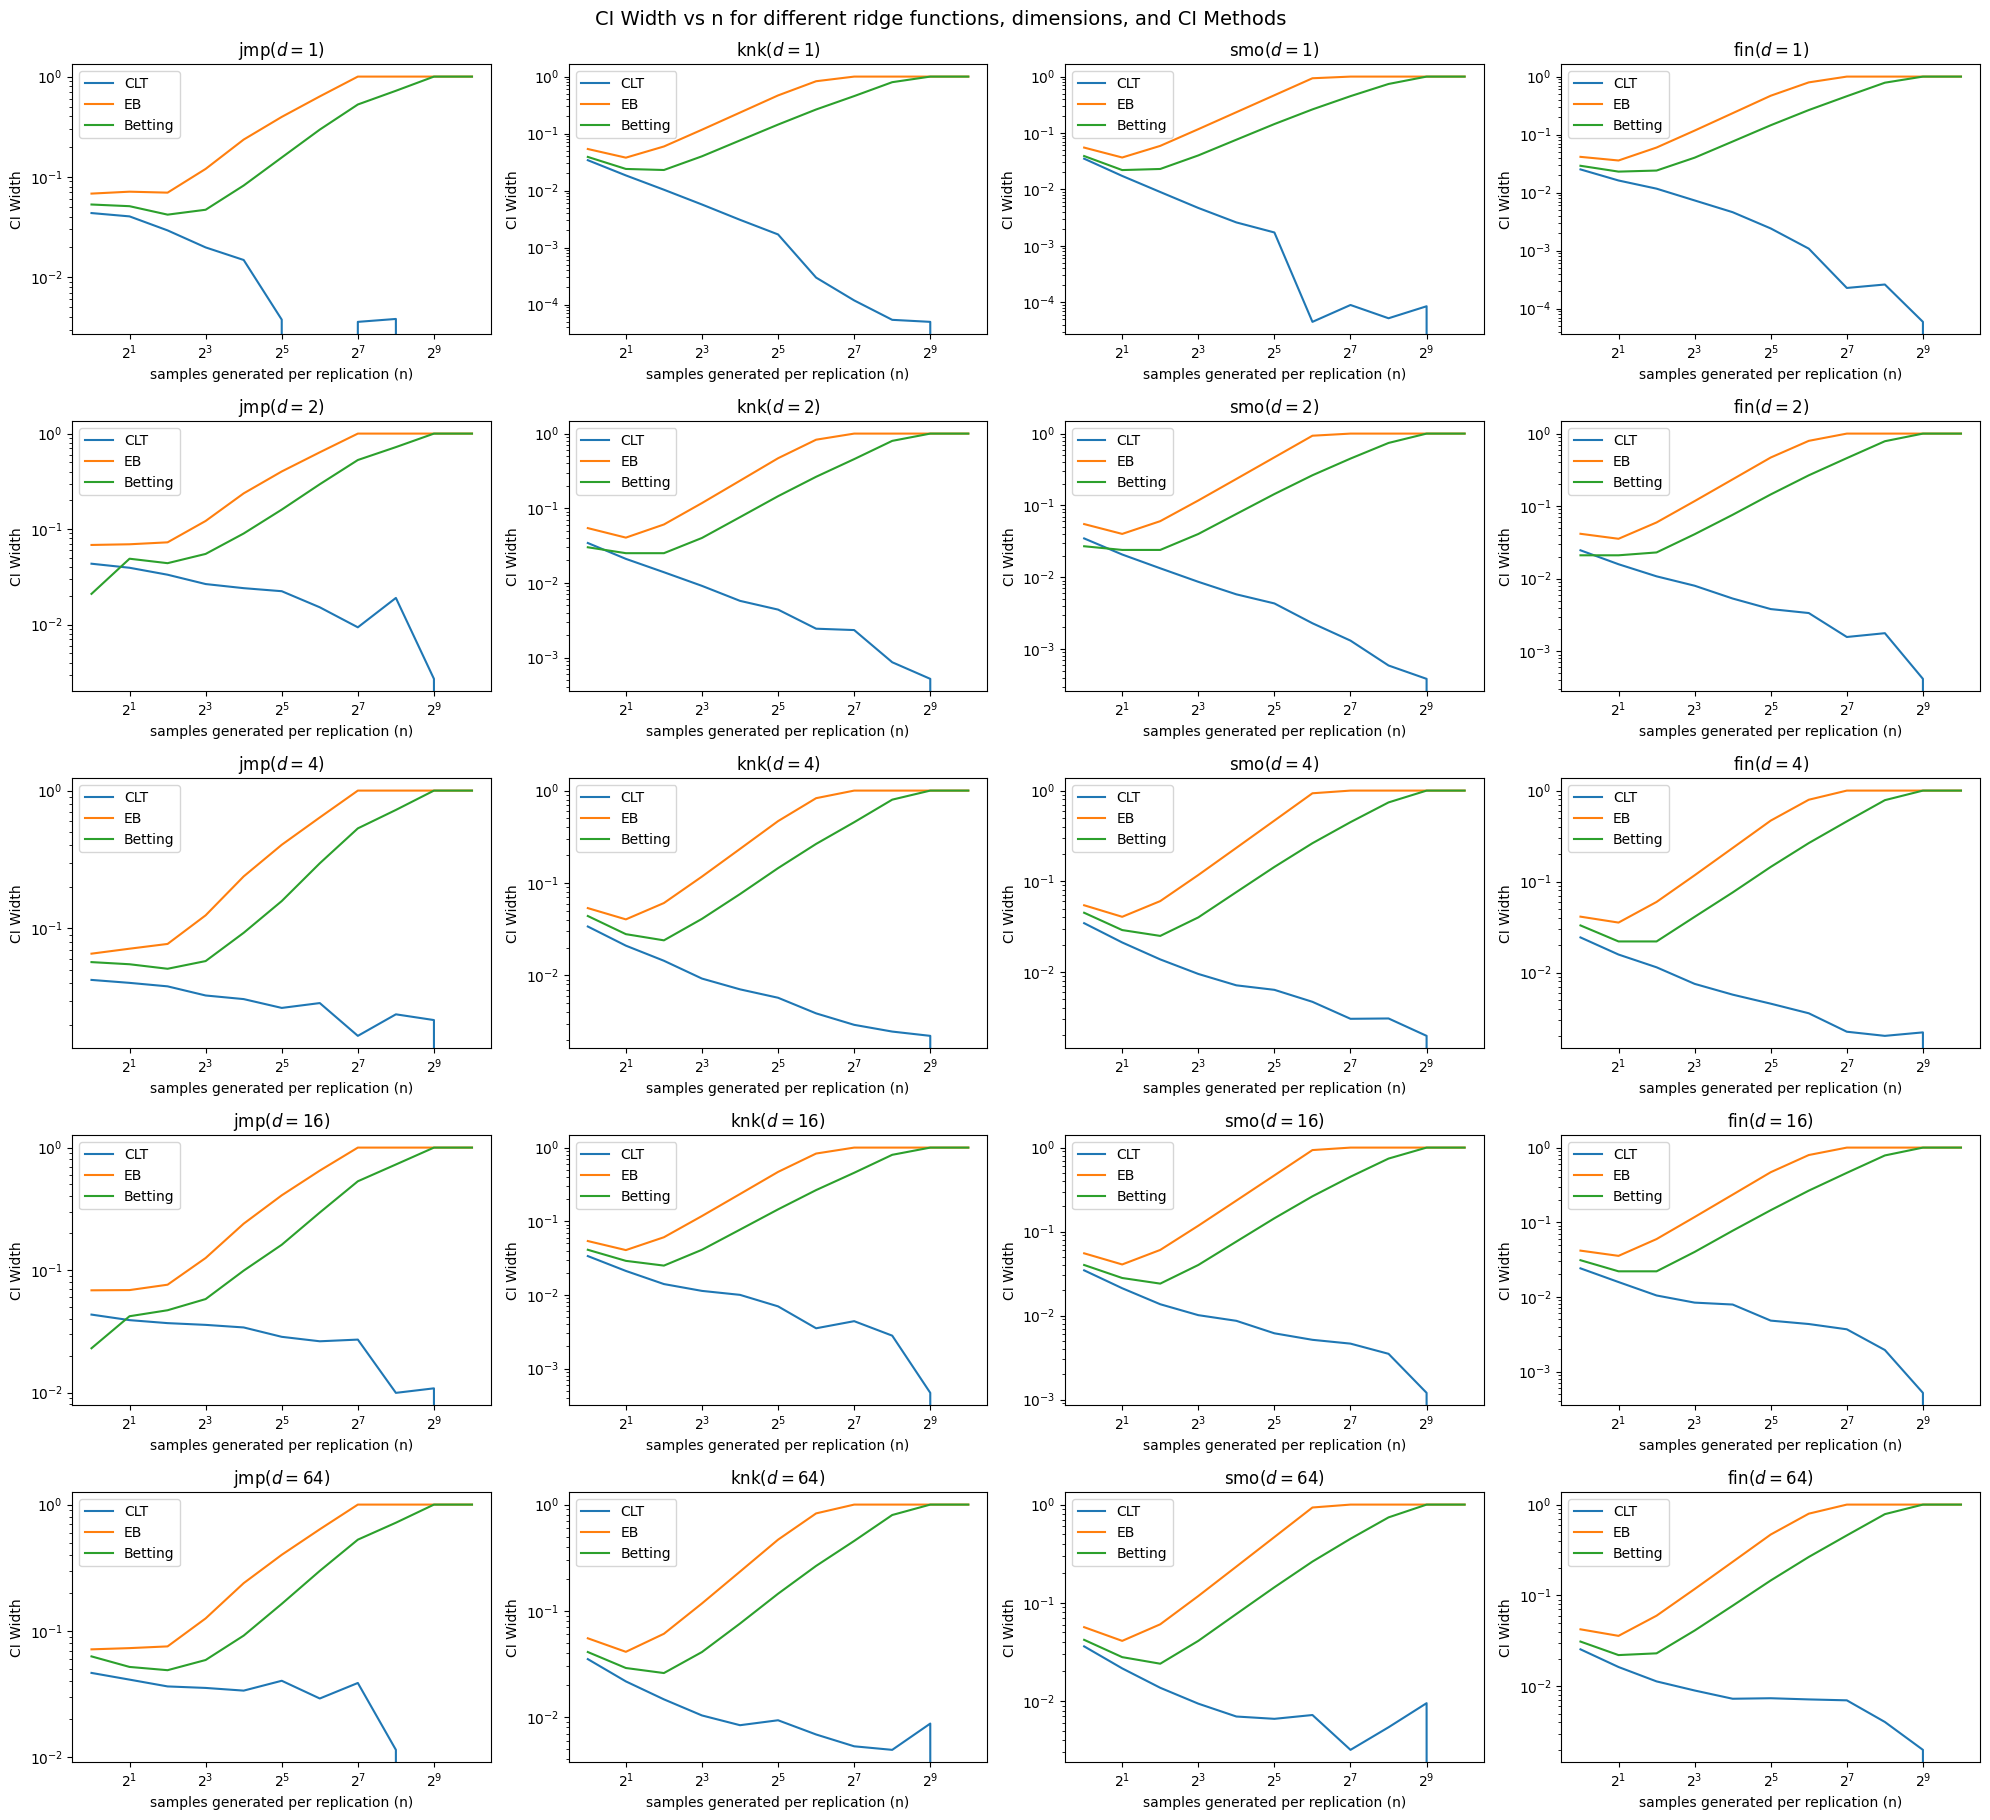

In [8]:
fig, axs = plt.subplots(len(d),len(gs),figsize=(20, 18))
for k in range (len(d)):
    for counter, name in enumerate(gs.keys()):
        for methods in range (len(ci_methods)):
            axs[k,counter].plot(n_vary, qmc_arr[methods,k,counter,:], label=f"{ci_methods[methods]}")
        axs[k,counter].set_xlabel("samples generated per replication (n)")
        axs[k,counter].set_ylabel("CI Width")
        axs[k,counter].set_title(f"{name}($d = {d[k]}$)")
        axs[k,counter].legend()
        axs[k,counter].set_xscale('log', base = 2)
        axs[k,counter].set_yscale('log')
fig.text(0.3,1,"CI Width vs n for different ridge functions, dimensions, and CI Methods", fontsize = 14)
fig.tight_layout()

Observations:
* In general, CLT < Betting < EB for the CI widths, which is to be expected.
* The optimum n is about $2^{10}$ or close to that for CLT. Smaller for Betting and EB at $n = 2$ or $n = 4$


Here, we print the $R$ and $n$ size at which we get the minimum CI according to the CLT, EB, and Betting CI method and compare it to the width for IID:

In [9]:
for dim in range (len(d)):
    print("\nFor d =", d[dim],":")
    counter = 0
    for name in gs.keys():
        print("")
        print("For ridge function", name,":")
        for ci in range(len(ci_methods)):
            print("The IID",ci_methods[ci], "width =", iid_arr[ci,dim,counter])
            min_val = np.min(qmc_arr[ci,dim,counter,:])
            min_indices = np.where(qmc_arr[ci,dim,counter,:] == min_val)[0]
            print("The IID_QMC",ci_methods[ci], "width is minimum when R =",R_vary[min_indices],"n =", n_vary[min_indices],"and the width =", min_val)
        counter = counter + 1


For d = 1 :

For ridge function jmp :
The IID CLT width = 0.026037506378509268
The IID_QMC CLT width is minimum when R = [16  2  1] n = [  64  512 1024] and the width = 0.0
The IID EB width = 0.06974730476589491
The IID_QMC EB width is minimum when R = [1024] n = [1] and the width = 0.06809983790368068
The IID Betting width = 0.05300000000000002
The IID_QMC Betting width is minimum when R = [256] n = [4] and the width = 0.04199999999999998

For ridge function knk :
The IID CLT width = 0.01982530449672116
The IID_QMC CLT width is minimum when R = [1] n = [1024] and the width = 0.0
The IID EB width = 0.054671518424519006
The IID_QMC EB width is minimum when R = [512] n = [2] and the width = 0.037865478154185395
The IID Betting width = 0.04200000000000004
The IID_QMC Betting width is minimum when R = [256] n = [4] and the width = 0.02300000000000002

For ridge function smo :
The IID CLT width = 0.02031377594117973
The IID_QMC CLT width is minimum when R = [1] n = [1024] and the width = 0

Observations:
* IID_QMC tends to perform better than IID. 

# Using Beta Distibution:

## Not varying the $R$ or $n$

The plot function used for both the IID_Beta and IID_QMC_Beta experiments:

In [10]:
def plot_func(times,lower_bound,upper_bound, title):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(times,lower_bound, color = "red")
    axs[0].plot(times,upper_bound, color = "red")
    axs[0].axhline(y=0.25, color="blue", linestyle="--")
    axs[1].plot(times,upper_bound - lower_bound, color = "red")
    axs[0].set_xlabel("sample size N") 
    axs[0].set_ylabel("Confidence Interval")
    axs[1].set_xlabel("sample size N") 
    axs[1].set_ylabel("CI Width")
    fig.text(0.45,1,title)
    fig.tight_layout()

IID_Beta Numerical Experiments

In [11]:
times_iid = (space_times * np.arange(1,num_times+1)) * n # The times (sample sizes) for which we'll compute the lower and upper bounds on the confidence intervals
x_iid = np.random.beta(beta_param[0], beta_param[1], N) # The IID_Beta samples
lower_bound_iid,upper_bound_iid = betting_ci_seq(x_iid, times=times_iid, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above


Using 14 cores


/Users/agsorok/miniconda3/envs/betci/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/agsorok/miniconda3/envs/betci/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/agsorok/miniconda3/envs/betci/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/agsorok/miniconda3/envs/betci/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/agsorok/miniconda3/envs/betci/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/agsorok/miniconda3/envs/betci/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: ove

IID_QMC_Beta Numerical Experiments

In [13]:
times_qmc = space_times * np.arange(1,num_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
x_qmc, beta_qmc = gen_qmc_samples_iid(distribution = qp.SciPyWrapper(sampler=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=beta_param[0], b = beta_param[1])), R=R, n=n) # The IID_QMC_Beta samples
lower_bound_qmc,upper_bound_qmc = betting_ci_seq(x_qmc, times=times_qmc, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above

Using 14 cores


Histograms and kernel density estimates of IID_Beta, QMC Transformed Beta Samples, and IID_QMC_Beta

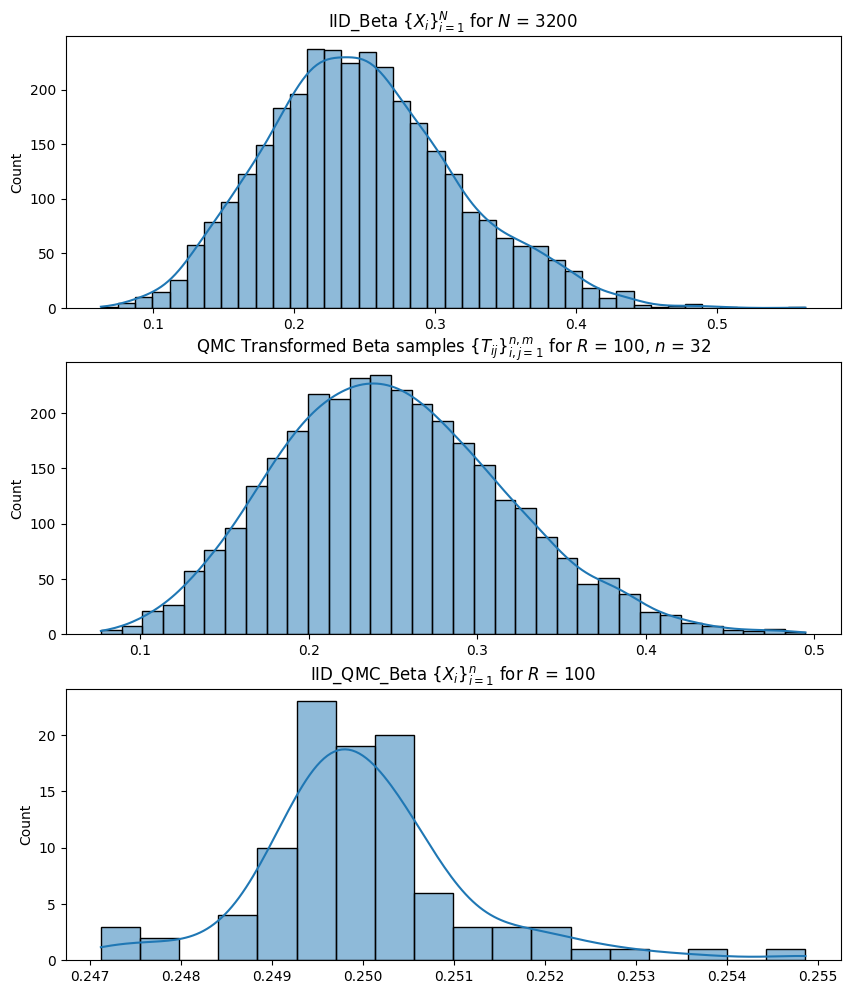

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

sns.histplot(x_iid, kde= True, ax=axs[0], edgecolor='black') # IID_Beta Hist and KDE
axs[0].set_title(f'IID_Beta {{$X_{{i}}$}}$_{{i=1}}^{{N}}$ for $N$ = {N}'); 

sns.histplot(beta_qmc, kde= True, ax=axs[1], edgecolor='black') # QMC Transformed Beta Samples Hist and KDE
axs[1].set_title(f'QMC Transformed Beta samples {{$T_{{ij}}$}}$_{{i,j=1}}^{{n,m}}$ for $R$ = {R}, $n$ = {n}'); 

sns.histplot(x_qmc, kde= True, ax=axs[2], edgecolor='black') # IID_QMC_Beta Hist and KDE
axs[2].set_title(f'IID_QMC_Beta {{$X_{{i}}$}}$_{{i=1}}^{{n}}$ for $R$ = {R}');


We note the following:
* The QMC Transformed Beta points (plot 2) make a smoother histogram than the IID_Beta points (plot 1).
* The $X_i$ from the IID_QMC_Beta points (plot 3) seem to have a heavy-tailed distribution.

## Simulation Plots

Here, we plot the confidence interval width as a function of sample size $N$ for IID_Beta and IID_QMC_Beta samples using the Hedged (Betting) CI method:

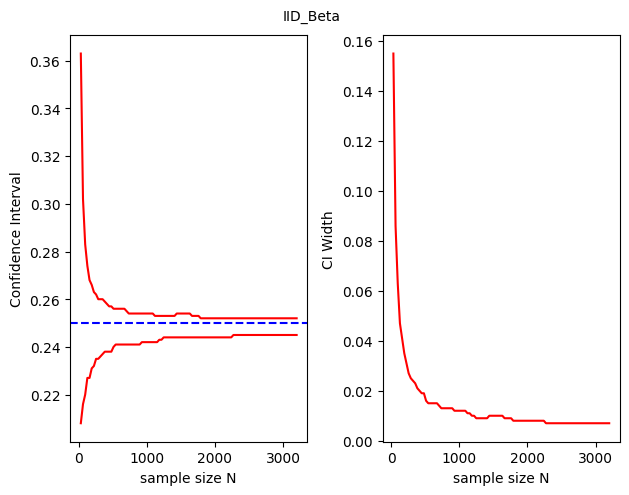

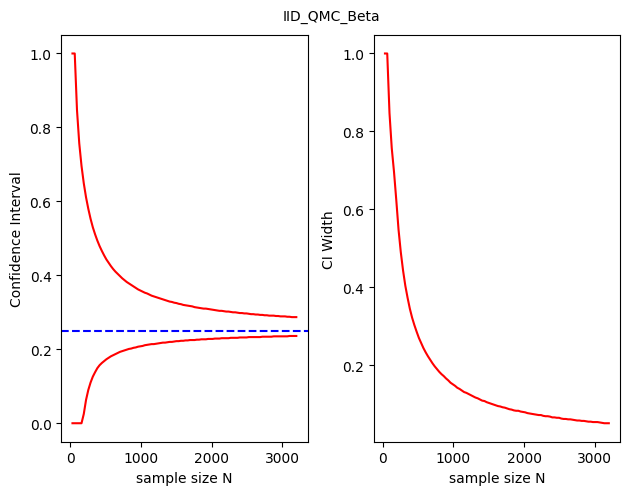

In [15]:
plot_func(times_iid,lower_bound_iid,upper_bound_iid,"IID_Beta") # IID_Beta Plot
plot_func(times_qmc * n,lower_bound_qmc,upper_bound_qmc,"IID_QMC_Beta") # IID_QMC_Beta Plot

## Printing the Simulation Output

Here, we print out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_Beta and IID_QMC_Beta based on a total of $N$ samples:


In [16]:
# Printing out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_Beta based on a total of N samples
print("IID_Beta mean for sample size N =", N, "is", x_iid.mean())
print("IID_Beta std for sample size N =", N, "is", x_iid.std())
print("IID_Beta Upper bound at sample size N =", N, "is", upper_bound_iid[len(upper_bound_iid) - 1])
print("IID_Beta Lower bound at sample size N =",N, "is", lower_bound_iid[len(lower_bound_iid) - 1])
print("IID_Beta Betting CI width at sample size N =",N, "is", upper_bound_iid[len(upper_bound_iid) - 1] - lower_bound_iid[len(lower_bound_iid) - 1])
print("The IID_Beta CLT CI width for sample size N =", N,"would be", norm.ppf(1 - alpha / 2) * x_iid.std() / np.sqrt(N))

print("")

# Printing out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_QMC_Beta based on a total of N samples
print("IID_QMC_Beta mean based on a total of N =", N, "is", x_qmc.mean())
print("IID_QMC_Beta std based on a total of N =", N, "is", x_qmc.std())
print("IID_QMC_Beta Upper bound based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1])
print("IID_QMC_Beta Lower bound based on a total of N =", N, "is", lower_bound_qmc[len(lower_bound_qmc) - 1])
print("IID_QMC_Beta Betting CI width based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1] - lower_bound_qmc[len(lower_bound_qmc) - 1])
print("The IID_QMC_Beta CLT CI width based on a total of N =", N,"would be", norm.ppf(1 - alpha / 2) * x_qmc.std() / np.sqrt(R))

IID_Beta mean for sample size N = 3200 is 0.24876371734733696
IID_Beta std for sample size N = 3200 is 0.0684100826237384
IID_Beta Upper bound at sample size N = 3200 is 0.252
IID_Beta Lower bound at sample size N = 3200 is 0.245
IID_Beta Betting CI width at sample size N = 3200 is 0.007000000000000006
The IID_Beta CLT CI width for sample size N = 3200 would be 0.0023702448783079126

IID_QMC_Beta mean based on a total of N = 3200 is 0.2500256448916641
IID_QMC_Beta std based on a total of N = 3200 is 0.0011696136073511298
IID_QMC_Beta Upper bound based on a total of N = 3200 is 0.28700000000000003
IID_QMC_Beta Lower bound based on a total of N = 3200 is 0.23600000000000002
IID_QMC_Beta Betting CI width based on a total of N = 3200 is 0.05100000000000002
The IID_QMC_Beta CLT CI width based on a total of N = 3200 would be 0.00022924005462361864


Some further observations and questions:
* The CLT CI width for IID_QMC_Beta is less than IID_Beta.
* In the case of IID_QMC_Beta, the CI computed by the Hedged (Betting) method is orders of magnitude larger than the CLT CI width for IID_QMC_Beta and larger than the Hedged (Betting) CI width for IID_Beta. Why is this? Could the heavy tailed distribution of IID_Beta_QMC samples (plot 3 of the Histogram and KDE distribution) explain it?

## Varying $R$ and $n$

Here, we vary the R and n for IID_QMC_Beta while keeping their product a constant. Note that R x n = N_vary. We will then identify the case where we get the minimum width for Betting CI and compare it to IID_Beta:

IID_Beta numerical experiments:

In [17]:
x_iid_vary = np.random.beta(beta_param[0], beta_param[1], N_vary) # The IID_Beta samples
lower_bound_iid_vary,upper_bound_iid_vary = betting_ci_seq(x_iid_vary, times=np.array([N_vary]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above
ci_iid_vary = upper_bound_iid_vary[0] - lower_bound_iid_vary[0] # The CI based on N_vary

Using 14 cores


IID_QMC_Beta numerical experiments:

In [19]:
ci_vector_qmc_vary = [] # The list of CIs for different n and R
for i in range (len(R_vary)):
    x_qmc_vary,beta_qmc_vary = gen_qmc_samples_iid(distribution = qp.SciPyWrapper(sampler=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=beta_param[0], b = beta_param[1])),R=R_vary[i],n=n_vary[i]) # The IID_QMC_Beta samples
    lower_bound_qmc_vary,upper_bound_qmc_vary = betting_ci_seq(x_qmc_vary, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
        # Getting the sequential CI according to the code from the paper above
    ci_vector_qmc_vary.append(upper_bound_qmc_vary[0] - lower_bound_qmc_vary[0]) # adding the current CI to the vector
ci_vector_qmc_vary = np.array(ci_vector_qmc_vary)


Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores


Here, we plot how the Betting CI width based on a total of N_vary changes as R and n change:

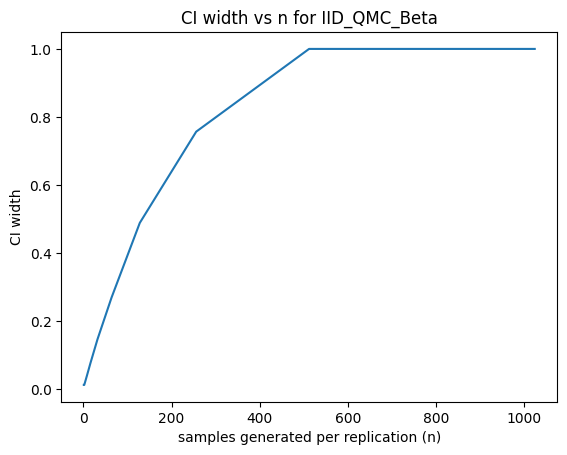

In [20]:
plt.plot(n_vary,ci_vector_qmc_vary);
plt.xlabel("samples generated per replication (n)");
plt.ylabel("CI width");
plt.title("CI width vs n for IID_QMC_Beta");

Some further observations:
* The CI width tends to decrease as number of IID replication (R) increases
* The plot looks asymptotic

Here, we print the R size at which we get the minimum CI according to the Betting CI method and compare it to the width for IID_Beta:

In [21]:
min_ci_qmc = np.min(ci_vector_qmc_vary) # The smallest CI width for IID_QMC_Beta
min_ci_index_qmc = np.argmin(ci_vector_qmc_vary) # The index at which we get the smallest CI width for IID_QMC_Beta

print("IID_Beta Betting CI width at sample size N_vary =",N_vary, "is", ci_iid_vary)
print("")
print("IID_QMC_Beta Betting CI width based on sample size N_vary =",N_vary, "is lowest when R =",R_vary[min_ci_index_qmc],
      "and n =",n_vary[min_ci_index_qmc],"\nThe CI width for this R and n is", min_ci_qmc)

IID_Beta Betting CI width at sample size N_vary = 1024 is 0.01100000000000001

IID_QMC_Beta Betting CI width based on sample size N_vary = 1024 is lowest when R = 1024 and n = 1 
The CI width for this R and n is 0.013000000000000012


Some further observations and questions:
* We get the least Betting CI width for IID_QMC_Beta when R = N_vary and n = 1. This is probably expected.
* The IID_Beta Betting CI width is pretty similar to the least IID_QMC_Beta CI width.
* Does it make sense to use the betting method for QMC when we get the best result when we're only generating 1 QMC point per replication, and that gives similar results to IID_Beta?

# Integrand Problem of $f(X) = \frac{X e^X}{e}$

## Varying $R$ and $n$

Here, we vary the R and n for IID replication of QMC samples while keeping their product a constant. Note that R x n = N_vary. We will then identify the case where we get the minimum width for Betting CI and empirical Bernstein CI and compare it to IID. We will also compare the two CI methods:

IID numerical experiments:

In [22]:
iid = qp.IIDStdUniform(1,seed=7) # IID generator
x_iid_integrand = iid.gen_samples(N_vary).reshape((R_vary[0],n_vary[0],iid.d))
y_iid_integrand = f(x_iid_integrand).flatten()
lower_bound_iid_integrand_bet,upper_bound_iid_integrand_bet = betting_ci_seq(y_iid_integrand, times=np.array([N_vary]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_iid_integrand_bet = upper_bound_iid_integrand_bet[0] - lower_bound_iid_integrand_bet[0] # The Betting CI based on N_vary
lower_bound_iid_integrand_eb,upper_bound_iid_integrand_eb = predmix_empbern_ci_seq(y_iid_integrand, times=np.array([N_vary]), alpha=alpha, parallel=True, truncation =1/2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_iid_integrand_eb = upper_bound_iid_integrand_eb[0] - lower_bound_iid_integrand_eb[0] # The EB CI based on N_vary

Using 14 cores
Using 14 cores


IID replications of QMC experiments:

In [23]:
ci_vector_qmc_integrand_bet = [] # The list of Betting CIs for different n and R
ci_vector_qmc_integrand_eb = [] # The list of EB CIs for different n and R
for i in range (len(R_vary)):
    y_rld_means,y_rld = gen_qmc_samples_iid(distribution=qp.DigitalNetB2(1,seed=7),R=R_vary[i],n=n_vary[i],function=f)
    lower_bound_qmc_integrand_bet,upper_bound_qmc_integrand_bet = betting_ci_seq(y_rld_means, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
    ci_vector_qmc_integrand_bet.append(upper_bound_qmc_integrand_bet[0] - lower_bound_qmc_integrand_bet[0]) # adding the current Betting CI to the vector
    lower_bound_qmc_integrand_eb,upper_bound_qmc_integrand_eb = predmix_empbern_ci_seq(y_rld_means, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, truncation=1 / 2) 
    # Getting the sequential EB CI according to the code from the paper above
    ci_vector_qmc_integrand_eb.append(upper_bound_qmc_integrand_eb[0] - lower_bound_qmc_integrand_eb[0]) # # adding the current EB CI to the vector
ci_vector_qmc_integrand_bet = np.array(ci_vector_qmc_integrand_bet)
ci_vector_qmc_integrand_eb = np.array(ci_vector_qmc_integrand_eb)


Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores


Here, we plot how the Betting CI and EB CI width based on a total of N_vary changes as R and n change:

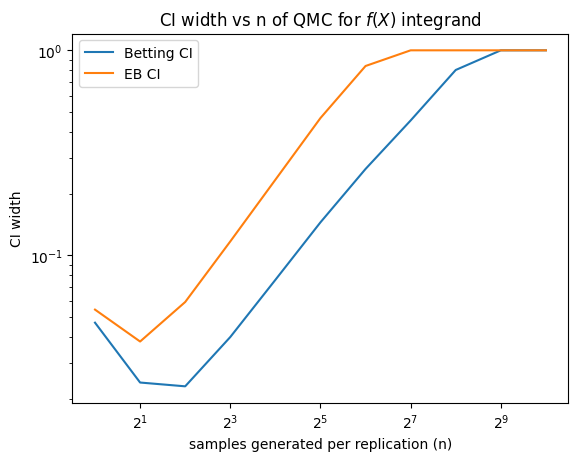

In [24]:
plt.plot(n_vary,ci_vector_qmc_integrand_bet, label = "Betting CI");
plt.plot(n_vary,ci_vector_qmc_integrand_eb, label = "EB CI");
plt.xlabel("samples generated per replication (n)");
plt.ylabel("CI width");
plt.title("CI width vs n of QMC for $f(X)$ integrand");
plt.legend();
plt.xscale('log', base = 2)
plt.yscale('log')

Some further observations:
* The CI width for both methods initially tends to decrease as number of IID replication (R) increases but tends to increase later
* Betting performs better for the most part

Here, we print the R and n size at which we get the minimum CI according to the Betting and EB CI method and compare it to the width for IID:

In [25]:
min_ci_qmc_bet = np.min(ci_vector_qmc_integrand_bet) # The smallest Betting CI width for IID replications of QMC
min_ci_index_qmc_bet = np.argmin(ci_vector_qmc_integrand_bet) # The index at which we get the smallest Betting CI width for IID Replications of QMC
min_ci_qmc_eb = np.min(ci_vector_qmc_integrand_eb) # The smallest EB CI width for IID replications of QMC
min_ci_index_qmc_eb = np.argmin(ci_vector_qmc_integrand_eb) # The index at which we get the smallest EB CI width for IID Replications of QMC

print("IID Betting CI width at sample size N_vary =",N_vary, "is", ci_iid_integrand_bet)
print("IID EB CI width at sample size N_vary =",N_vary, "is", ci_iid_integrand_eb)
print("")
print("IID Replications of QMC Betting CI width based on sample size N_vary =",N_vary, "is lowest when R =",R_vary[min_ci_index_qmc_bet],
      "and n =",n_vary[min_ci_index_qmc_bet],"\nThe CI width for this R and n is", min_ci_qmc_bet)
print("")
print("IID Replications of QMC EB CI width based on sample size N_vary =",N_vary, "is lowest when R =",R_vary[min_ci_index_qmc_eb],
      "and n =",n_vary[min_ci_index_qmc_eb],"\nThe CI width for this R and n is", min_ci_qmc_eb)

IID Betting CI width at sample size N_vary = 1024 is 0.044999999999999984
IID EB CI width at sample size N_vary = 1024 is 0.05510102333457295

IID Replications of QMC Betting CI width based on sample size N_vary = 1024 is lowest when R = 256 and n = 4 
The CI width for this R and n is 0.02300000000000002

IID Replications of QMC EB CI width based on sample size N_vary = 1024 is lowest when R = 512 and n = 2 
The CI width for this R and n is 0.03803322171275253


Some further observations:
* The CIs through IID replications of QMC perform better than IID
* Betting CI performs better than EB CI for QMC and similar for plain IID (a bit better for EB)

## Not varying $R$ and $n$

Here, we will use the R and n size at which we obtained the minimum Betting CI width for IID replications of QMC from the previous integrand experiment.

Here, we set the num_times, R, n, and N

In [26]:
num_times = R_vary[min_ci_index_qmc_bet] #number of different times where CI will be computed
R = num_times * space_times # The number of IID replications for low discrepancy or QMC samples
n = n_vary[min_ci_index_qmc_bet] # The number of low discrepancy or QMC samples generated per replication
N = R * n # The maximum sample size (N = mn)

IID numerical experiments:

In [27]:
times_iid_integrand = (space_times * np.arange(1,num_times+1)) * n # The times (sample sizes) for which we'll compute the lower and upper bounds on the confidence intervals
iid_fixed = qp.IIDStdUniform(1,seed=7) # IID generator
x_iid_integrand_fixed = iid_fixed.gen_samples(N).reshape(R,n,iid_fixed.d)
y_iid_integrand_fixed = f(x_iid_integrand_fixed).flatten()
lower_bound_iid_integrand_bet_fixed,upper_bound_iid_integrand_bet_fixed = betting_ci_seq(y_iid_integrand_fixed, times=times_iid_integrand, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_iid_integrand_bet_fixed = upper_bound_iid_integrand_bet_fixed - lower_bound_iid_integrand_bet_fixed # The Betting CIs for different times in time_iid_integrand
lower_bound_iid_integrand_eb_fixed,upper_bound_iid_integrand_eb_fixed = predmix_empbern_ci_seq(y_iid_integrand_fixed, times=times_iid_integrand, alpha=alpha, parallel=True, truncation =1/2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_iid_integrand_eb_fixed = upper_bound_iid_integrand_eb_fixed - lower_bound_iid_integrand_eb_fixed # The EB CIs for different times in time_iid_integrand

Using 14 cores
Using 14 cores


IID replications of QMC experiments:

In [28]:
times_qmc_integrand = space_times * np.arange(1,num_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
y_rld_means_integrand,y_rld_integrand = gen_qmc_samples_iid(distribution=qp.DigitalNetB2(1,seed=7),R=R,n=n,function=f)
lower_bound_qmc_integrand_bet_fixed,upper_bound_qmc_integrand_bet_fixed = betting_ci_seq(y_rld_means_integrand, times=times_qmc_integrand, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_qmc_integrand_bet_fixed = upper_bound_qmc_integrand_bet_fixed - lower_bound_qmc_integrand_bet_fixed # The Betting CIs for different times in time_qmc_integrand
lower_bound_qmc_integrand_eb_fixed,upper_bound_qmc_integrand_eb_fixed = predmix_empbern_ci_seq(y_rld_means_integrand, times=times_qmc_integrand, alpha=alpha, parallel=True, truncation=1 / 2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_qmc_integrand_eb_fixed = upper_bound_qmc_integrand_eb_fixed - lower_bound_qmc_integrand_eb_fixed # The EB CIs for different times in time_qmc_integrand

Using 14 cores
Using 14 cores


## Simulation Plots

Here, we plot the confidence interval width as a function of sample size $N$ for IID and IID replications of QMC using the Hedged (Betting) and EB CI method:

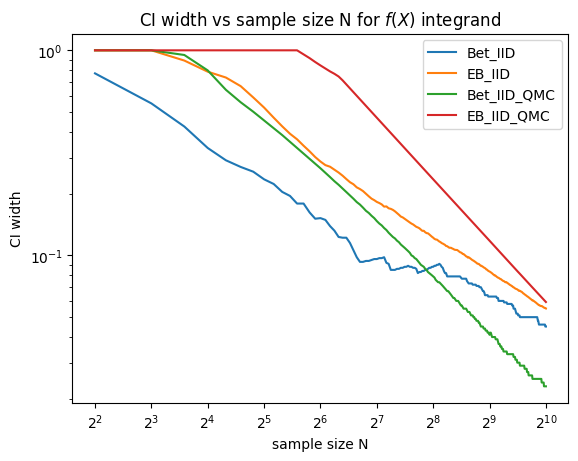

In [29]:
plt.plot(times_iid_integrand,ci_iid_integrand_bet_fixed,label = "Bet_IID");
plt.plot(times_iid_integrand,ci_iid_integrand_eb_fixed,label = "EB_IID");
plt.plot(times_qmc_integrand * n,ci_qmc_integrand_bet_fixed,label = "Bet_IID_QMC");
plt.plot(times_qmc_integrand * n,ci_qmc_integrand_eb_fixed,label = "EB_IID_QMC");
plt.ylabel("CI width");
plt.xlabel("sample size N");
plt.legend();
plt.title("CI width vs sample size N for $f(X)$ integrand");
plt.xscale('log', base = 2)
plt.yscale('log')

Some further observations:
* Bet_IID_QMC performs the best after some time
* Eventually, CIs through QMC perform the best, even EB_IID_QMC performs better than Bet_IID

# Integrand Problem of $f(X, Y) = \begin{cases} 1, & \text{if } X + Y > \frac{2}{3} \\0, & \text{otherwise}\end{cases}$

## Varying $R$ and $n$

Here, we vary the R and n for IID replication of QMC samples while keeping their product a constant. Note that R x n = N_vary. We will then identify the case where we get the minimum width for Betting CI and empirical Bernstein CI and compare it to IID. We will also compare the two CI methods:

IID numerical experiments:

In [30]:
iid = qp.IIDStdUniform(2,seed=7) # IID generator
x_iid_integrand = iid.gen_samples(N_vary).reshape((R_vary[0],n_vary[0],iid.d))
y_iid_integrand = f_1(x_iid_integrand).flatten()
lower_bound_iid_integrand_bet,upper_bound_iid_integrand_bet = betting_ci_seq(y_iid_integrand, times=np.array([N_vary]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_iid_integrand_bet = upper_bound_iid_integrand_bet[0] - lower_bound_iid_integrand_bet[0] # The Betting CI based on N_vary
lower_bound_iid_integrand_eb,upper_bound_iid_integrand_eb = predmix_empbern_ci_seq(y_iid_integrand, times=np.array([N_vary]), alpha=alpha, parallel=True, truncation =1/2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_iid_integrand_eb = upper_bound_iid_integrand_eb[0] - lower_bound_iid_integrand_eb[0] # The EB CI based on N_vary

Using 14 cores
Using 14 cores


IID replications of QMC experiments:

In [31]:
ci_vector_qmc_integrand_bet = [] # The list of Betting CIs for different n and R
ci_vector_qmc_integrand_eb = [] # The list of EB CIs for different n and R
for i in range (len(R_vary)):
    y_rld_means,y_rld = gen_qmc_samples_iid(distribution=qp.DigitalNetB2(2,seed = 7),R=R_vary[i],n=n_vary[i],function=f_1,d_func = 2)
    lower_bound_qmc_integrand_bet,upper_bound_qmc_integrand_bet = betting_ci_seq(y_rld_means, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
    ci_vector_qmc_integrand_bet.append(upper_bound_qmc_integrand_bet[0] - lower_bound_qmc_integrand_bet[0]) # adding the current Betting CI to the vector
    lower_bound_qmc_integrand_eb,upper_bound_qmc_integrand_eb = predmix_empbern_ci_seq(y_rld_means, times=np.array([R_vary[i]]), alpha=alpha, parallel=True, truncation=1 / 2) 
    # Getting the sequential EB CI according to the code from the paper above
    ci_vector_qmc_integrand_eb.append(upper_bound_qmc_integrand_eb[0] - lower_bound_qmc_integrand_eb[0]) # # adding the current EB CI to the vector 
ci_vector_qmc_integrand_bet = np.array(ci_vector_qmc_integrand_bet)
ci_vector_qmc_integrand_eb = np.array(ci_vector_qmc_integrand_eb)

Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores
Using 14 cores


Here, we plot how the Betting CI and EB CI width based on a total of N_vary changes as R and n change:

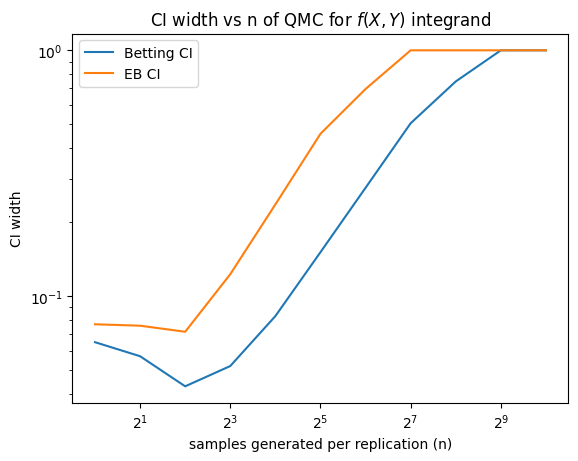

In [32]:
plt.plot(n_vary,ci_vector_qmc_integrand_bet, label = "Betting CI");
plt.plot(n_vary,ci_vector_qmc_integrand_eb, label = "EB CI");
plt.xlabel("samples generated per replication (n)");
plt.ylabel("CI width");
plt.title("CI width vs n of QMC for $f(X, Y)$ integrand")
plt.legend();
plt.xscale('log', base = 2)
plt.yscale('log')

Some further observations:
* The CI width for both methods initially tends to decrease as number of IID replication (R) increases but tends to slightly increase later
* Betting CI performs better for most part

Here, we print the R and n size at which we get the minimum CI according to the Betting and EB CI method and compare it to the width for IID:

In [33]:
min_ci_qmc_bet = np.min(ci_vector_qmc_integrand_bet) # The smallest Betting CI width for IID replications of QMC
min_ci_index_qmc_bet = np.argmin(ci_vector_qmc_integrand_bet) # The index at which we get the smallest Betting CI width for IID Replications of QMC
min_ci_qmc_eb = np.min(ci_vector_qmc_integrand_eb) # The smallest EB CI width for IID replications of QMC
min_ci_index_qmc_eb = np.argmin(ci_vector_qmc_integrand_eb) # The index at which we get the smallest EB CI width for IID Replications of QMC

print("IID Betting CI width at sample size N_vary =",N_vary, "is", ci_iid_integrand_bet)
print("IID EB CI width at sample size N_vary =",N_vary, "is", ci_iid_integrand_eb)
print("")
print("IID Replications of QMC Betting CI width based on sample size N_vary =",N_vary, "is lowest when R =",R_vary[min_ci_index_qmc_bet],
      "and n =",n_vary[min_ci_index_qmc_bet],"\nThe CI width for this R and n is", min_ci_qmc_bet)
print("")
print("IID Replications of QMC EB CI width based on sample size N_vary =",N_vary, "is lowest when R =",R_vary[min_ci_index_qmc_eb],
      "and n =",n_vary[min_ci_index_qmc_eb],"\nThe CI width for this R and n is", min_ci_qmc_eb)

IID Betting CI width at sample size N_vary = 1024 is 0.05900000000000005
IID EB CI width at sample size N_vary = 1024 is 0.07830412540922149

IID Replications of QMC Betting CI width based on sample size N_vary = 1024 is lowest when R = 256 and n = 4 
The CI width for this R and n is 0.04300000000000004

IID Replications of QMC EB CI width based on sample size N_vary = 1024 is lowest when R = 256 and n = 4 
The CI width for this R and n is 0.07167585437645108


Some further observations:
* The CIs through IID replications of QMC perform better than IID
* Betting CI performs better than EB CI although quite similar for plain IID

## Not varying $R$ and $n$

Here, we will use the R and n size at which we obtained the minimum Betting CI width for IID replications of QMC from the previous integrand experiment.

Here, we set the num_times, R, n, and N

In [34]:
num_times = R_vary[min_ci_index_qmc_bet] #number of different times where CI will be computed
R = num_times * space_times # The number of IID replications for low discrepancy or QMC samples
n = n_vary[min_ci_index_qmc_bet] # The number of low discrepancy or QMC samples generated per replication
N = R * n # The maximum sample size (N = mn)

IID numerical experiments

In [35]:
times_iid_integrand = (space_times * np.arange(1,num_times+1)) * n # The times (sample sizes) for which we'll compute the lower and upper bounds on the confidence intervals
iid_fixed = qp.IIDStdUniform(2,seed=7) # IID generator
x_iid_integrand_fixed = iid_fixed.gen_samples(N).reshape(R,n,iid_fixed.d)
y_iid_integrand_fixed = f_1(x_iid_integrand_fixed).flatten()
lower_bound_iid_integrand_bet_fixed,upper_bound_iid_integrand_bet_fixed = betting_ci_seq(y_iid_integrand_fixed, times=times_iid_integrand, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_iid_integrand_bet_fixed = upper_bound_iid_integrand_bet_fixed - lower_bound_iid_integrand_bet_fixed # The Betting CIs for different times in time_iid_integrand
lower_bound_iid_integrand_eb_fixed,upper_bound_iid_integrand_eb_fixed = predmix_empbern_ci_seq(y_iid_integrand_fixed, times=times_iid_integrand, alpha=alpha, parallel=True, truncation =1/2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_iid_integrand_eb_fixed = upper_bound_iid_integrand_eb_fixed - lower_bound_iid_integrand_eb_fixed # The EB CIs for different times in time_iid_integrand

Using 14 cores
Using 14 cores


IID replications of QMC experiments:

In [36]:
times_qmc_integrand = space_times * np.arange(1,num_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
y_rld_means_integrand,y_rld_integrand = gen_qmc_samples_iid(distribution=qp.DigitalNetB2(2,seed = 7),R=R,n=n,function=f_1,d_func = 2)
lower_bound_qmc_integrand_bet_fixed,upper_bound_qmc_integrand_bet_fixed = betting_ci_seq(y_rld_means_integrand, times=times_qmc_integrand, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_qmc_integrand_bet_fixed = upper_bound_qmc_integrand_bet_fixed - lower_bound_qmc_integrand_bet_fixed # The Betting CIs for different times in time_qmc_integrand
lower_bound_qmc_integrand_eb_fixed,upper_bound_qmc_integrand_eb_fixed = predmix_empbern_ci_seq(y_rld_means_integrand, times=times_qmc_integrand, alpha=alpha, parallel=True, truncation=1 / 2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_qmc_integrand_eb_fixed = upper_bound_qmc_integrand_eb_fixed - lower_bound_qmc_integrand_eb_fixed # The EB CIs for different times in time_qmc_integrand

Using 14 cores
Using 14 cores


## Simulation Plots

Here, we plot the confidence interval width as a function of sample size $N$ for IID and IID replications of QMC using the Hedged (Betting) and EB CI method:

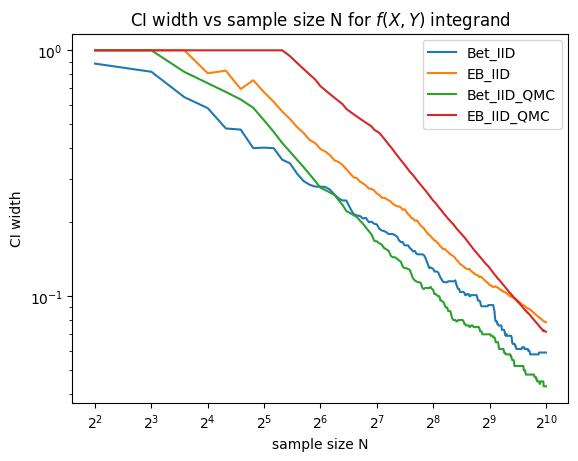

In [37]:
plt.plot(times_iid_integrand,ci_iid_integrand_bet_fixed,label = "Bet_IID");
plt.plot(times_iid_integrand,ci_iid_integrand_eb_fixed,label = "EB_IID");
plt.plot(times_qmc_integrand * n,ci_qmc_integrand_bet_fixed,label = "Bet_IID_QMC");
plt.plot(times_qmc_integrand * n,ci_qmc_integrand_eb_fixed,label = "EB_IID_QMC");
plt.ylabel("CI width");
plt.xlabel("sample size N");
plt.legend();
plt.title("CI width vs sample size N for $f(X,Y)$ integrand");
plt.xscale('log', base = 2)
plt.yscale('log')

Some further observations:
* Bet_IID_QMC performs the best after some time
* Eventually, CIs through QMC perform the best, even EB_IID_QMC performs better than Bet_IID